In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import gym
import vgdl.interfaces.gym as vdgym
import vgdl
import numpy as np

In [2]:
vdgym.register_sample_games()

In [3]:
vdgym.list_space

<module 'vgdl.interfaces.gym.list_space' from 'F:\\Download\\py-vgdl\\vgdl\\interfaces\\gym\\list_space.py'>

In [4]:
gym.envs.registry

├──CartPole: [ v0, v1 ]
├──MountainCar: [ v0 ]
├──MountainCarContinuous: [ v0 ]
├──Pendulum: [ v1 ]
├──Acrobot: [ v1 ]
├──LunarLander: [ v2 ]
├──LunarLanderContinuous: [ v2 ]
├──BipedalWalker: [ v3 ]
├──BipedalWalkerHardcore: [ v3 ]
├──CarRacing: [ v1 ]
├──Blackjack: [ v1 ]
├──FrozenLake: [ v1 ]
├──FrozenLake8x8: [ v1 ]
├──CliffWalking: [ v0 ]
├──Taxi: [ v3 ]
├──Reacher: [ v2 ]
├──Pusher: [ v2 ]
├──InvertedPendulum: [ v2 ]
├──InvertedDoublePendulum: [ v2 ]
├──HalfCheetah: [ v2, v3 ]
├──Hopper: [ v2, v3 ]
├──Swimmer: [ v2, v3 ]
├──Walker2d: [ v2, v3 ]
├──Ant: [ v2, v3 ]
├──Humanoid: [ v2, v3 ]
├──HumanoidStandup: [ v2 ]
├──vgdl_aliens: [ v0 ]
├──vgdl_aliens_objects: [ v0 ]
├──vgdl_aliens_features: [ v0 ]
├──vgdl_boulderdash: [ v0 ]
├──vgdl_boulderdash_objects: [ v0 ]
├──vgdl_boulderdash_features: [ v0 ]
├──vgdl_chase: [ v0 ]
├──vgdl_chase_objects: [ v0 ]
├──vgdl_chase_features: [ v0 ]
├──vgdl_frogs: [ v0 ]
├──vgdl_frogs_objects: [ v0 ]
├──vgdl_frogs_features: [ v0 ]
├──vgdl_missilecomma

In [5]:
game = gym.make('vgdl_sokoban-v0')
game.reset()

AttributeError: 'NoneType' object has no attribute 'get_image'

In [6]:
import gnwrapper
import gym

env = gnwrapper.Animation(gym.make('vgdl_zelda-v0', obs_type="objects"))
env = gym.make('vgdl_zelda-v0', obs_type="objects")
env.render()
obs = env.reset()

for _ in range(1000):
    next_obs, reward, done, info = env.step(env.action_space.sample())
    env.render()

    obs = next_obs
    #print(obs.shape)
    #print(obs)
    #print(env.notable_sprites)
    print(env.game.get_game_state())
    break

    if done:
        obs = env.reset()

GameState(time=1, score=0, reward=0, ended=False, avatar=(pos=(101, 20), alive=True))


In [7]:
def get_sprite_positions(data, env):
    pos_lst = []
    block_size = env.game.block_size
    for i in data:
        rect = i['state']['rect']
        pos = (rect.top, rect.left)
        pos_lst.append(pos)

    return pos_lst


/home/jan/miniconda3/envs/fastai/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
import itertools
import heapq as hq
from dataclasses import dataclass, field
from typing import Any,List,Tuple

@dataclass(order=True)
class Subgoal:
    priority: int
    previous_actions: list
    info: Any=field(compare=False)


class PriorityQueue:
    def __init__(self):
        self.elements: List[Subgoal] = []

    def empty(self) -> bool:
        return not self.elements

    def put(self, item: Subgoal):
        hq.heappush(self.elements,item)

    def get(self) -> Subgoal:
        return hq.heappop(self.elements)

    def merge(self,items: List):
        for item in items:
            hq.heappush(self.elements,item)

In [9]:
from itertools import product
import networkx as nx
def get_distances(env):
    h,w = env.game.height,env.game.width
    bs = env.game.block_size
    grid = np.zeros((h*bs,w*bs))
    for w in env.game.get_game_state().data['sprites']['wall']:
        pos = w['state']['rect'].top,w['state']['rect'].left
        for i in range(-bs+1,bs):
            for j in range(-bs+1,bs):
                x = pos[0]+i
                y = pos[1]+j
                if x>=0 and y>=0:
                    grid[x,y]=1
    coor = np.array(list(product(*map(range, grid.shape))))
    G = nx.grid_2d_graph(*grid.shape)
    G.remove_nodes_from(map(tuple, coor[grid.flatten() == 1]))
    return dict(nx.all_pairs_shortest_path_length(G))


In [31]:
env = gym.make('vgdl_zelda-v0', obs_type="objects")
all_distances = get_distances(env)

In [38]:

def evaluate_state(env, distances_dict):
    block_size = env.game.block_size
    bad_lst = ['monsterQuick', 'monsterNormal', 'monsterSlow']
    avatar_name = env.game.get_avatars()[-1].key
    if avatar_name=='withkey2':
        sub_goal = 'goal'
    else:
        sub_goal = 'key'
    bad_pos_lst = []
    pos = env.game.get_game_state().data['sprites'][sub_goal]
    sub_goal_pos_lst = get_sprite_positions(pos, env)
    rect = env.game.get_avatars()[-1].rect
    agent_pos = rect.top, rect.left 
    print(agent_pos)
    for i in bad_lst:
        pos = env.game.get_game_state().data['sprites'][i]
        bad_pos_lst += get_sprite_positions(pos, env)
    sub_goal_distances = []
    for i in sub_goal_pos_lst:
        if i in distances_dict[agent_pos]:
            sub_goal_distances.append(distances_dict[agent_pos][i])
    enemy_distances = [40]
    for i in bad_pos_lst:
        if i in distances_dict[agent_pos]:
            enemy_distances.append(distances_dict[agent_pos][i])
            

    min_sub_goal_dist = min(sub_goal_distances)
    min_enemy_dist = min(enemy_distances)
    if min_enemy_dist<15:
        score = 10**6
    else: score = 2*min_sub_goal_dist - min_enemy_dist


    return score, min_sub_goal_dist,min_enemy_dist

In [42]:
env = gym.make('vgdl_zelda-v0', obs_type="objects")
obs = env.reset()
first_state_info = env.game.get_game_state()
first_state = Subgoal(priority=0, previous_actions=[],\
                      info=first_state_info)
frontier = PriorityQueue()
frontier.put(first_state)

def visualize_actions(action_list, current_state):
    env = gnwrapper.Animation(gym.make('vgdl_zelda-v0', obs_type="objects"))
    env.reset()
    env.game.set_game_state(current_state)
    print(current_state.keys())
    for i in action_list:
        next_obs, reward, done, info = env.step(i)
        env.render()
    return env
seen_states = {first_state_info}
switched = False
done = False
for i in range(1000):
    if done:
        break
    if len(frontier.elements)==0:
        #print(f"no more subgoals on {i}th iteration")
        break
    #else: print('frontier size:',len(frontier.elements))
    current = frontier.get()
    state = current.info
    env.game.set_game_state(state)
    for i, a in enumerate(env.game.get_possible_actions()):
        next_obs, reward, done, info = env.step(i)
        if not env.game.get_game_state().avatar_state['state']['alive']:
            env.game.set_game_state(state)
            print('death',"*"*20)
            continue # here should be continue...check for win 
        new_state = env.game.get_game_state()
        
        if new_state in seen_states:
            env.game.set_game_state(state)
            continue
        seen_states.add(new_state)
        actions = current.previous_actions+[i]
        score, min_subgoal,min_enemy = evaluate_state(env, all_distances)
        if len(env.game.get_avatars())==2 and not switched:
            frontier = PriorityQueue()
            print(kk)
            seen_states = {new_state}
            switched = True
            new_goal = Subgoal(score, actions, new_state)
            frontier.put(new_goal)
            print("*"*50)
            break
        else:
            print(score,min_subgoal,min_enemy)
            new_goal = Subgoal(score, actions, new_state)
            frontier.put(new_goal)
            env.game.set_game_state(state)
        if env.game.get_game_state().ended():
            tmp_state = new_goal
            print('done','*'*20)
            done=True
            break
        
#tmp_state = frontier.get()
#tmp_state = frontier.get()
#print(tmp_state.previous_actions)
#env = visualize_actions(tmp_state.previous_actions, first_state_info)

(10, 20)
160 100 40
(11, 20)
162 101 40
(10, 19)
162 101 40
(10, 21)
158 99 40
(10, 20)
160 100 40
(10, 21)
158 99 40
(10, 21)
158 99 40
(10, 20)
160 100 40
(10, 22)
156 98 40
(10, 21)
158 99 40
(10, 22)
156 98 40
(10, 22)
156 98 40
(10, 21)
158 99 40
(10, 23)
154 97 40
(10, 22)
156 98 40
(10, 23)
154 97 40
(10, 23)
154 97 40
(10, 22)
156 98 40
(10, 24)
152 96 40
(10, 23)
154 97 40
(10, 24)
152 96 40
(10, 24)
152 96 40
(10, 23)
154 97 40
(10, 25)
150 95 40
(10, 24)
152 96 40
(10, 25)
150 95 40
(10, 25)
150 95 40
(10, 24)
152 96 40
(10, 26)
148 94 40
(10, 25)
150 95 40
(10, 26)
148 94 40
(10, 26)
148 94 40
(10, 25)
150 95 40
(10, 27)
146 93 40
(10, 26)
148 94 40
(10, 27)
146 93 40
(10, 27)
146 93 40
(10, 26)
148 94 40
(10, 28)
144 92 40
(10, 27)
146 93 40
(10, 28)
144 92 40
(10, 28)
144 92 40
(10, 27)
146 93 40
(10, 29)
142 91 40
(10, 28)
144 92 40
(10, 29)
142 91 40
(10, 29)
142 91 40
(10, 28)
144 92 40
(10, 30)
140 90 40
(10, 29)
142 91 40
(10, 30)
140 90 40
(10, 30)
140 90 40
(10, 29

NameError: name 'kk' is not defined

In [43]:
%debug

> <ipython-input-42-f55cd97c3e61>(47)<module>()
     45         if len(env.game.get_avatars())==2 and not switched:
     46             frontier = PriorityQueue()
---> 47             print(kk)
     48             seen_states = {new_state}
     49             switched = True



ipdb>  env.game.get_avatars()


[nokey `nokey.1` at (91, 21), withkey2 `withkey2.1` at (91, 21)]


ipdb>  env.game.get_avatars()[1]


withkey2 `withkey2.1` at (91, 21)


ipdb>  dir(env.game.get_avatars()[1])


['COLOR_DISC', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_draw', '_effect_data', '_has_ammo', '_read_action', '_shoot', '_shoot_directions', '_spend_ammo', '_update_position', 'alive', 'alternate_keys', 'ammo', 'color', 'cooldown', 'count_resource', 'declare_possible_actions', 'draw_arrow', 'frameRate', 'get_game_state', 'has_resource', 'id', 'img', 'img_orient', 'is_avatar', 'is_static', 'is_stochastic', 'key', 'keys_to_action', 'lastdirection', 'lastmove', 'lastrect', 'mass', 'only_active', 'orientation', 'physics', 'physicstype', 'rect', 'resources', 'rng', 'set_game_state', 'shrinkfactor', 'speed', 'state_attributes', 'stype', 'stypes', 'update', 'velocity']


ipdb>  env.game.get_avatars()[1].speed


1


ipdb>  env.game.get_avatars()[0].speed


1


ipdb>  exit


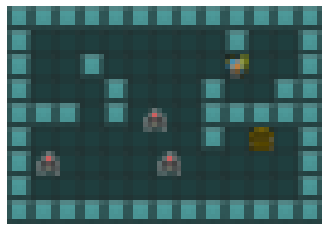

<Animation<OrderEnforcing<VGDLEnv<vgdl_zelda-v0>>>>

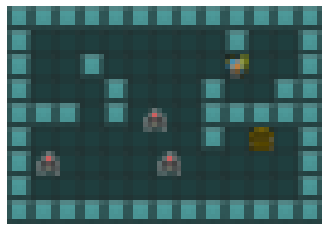

In [41]:
def visualize_actions(env,action_list, current_state):
    action_list = action_list
    env = gnwrapper.Animation(gym.make('vgdl_zelda-v0', obs_type="objects"))
    env.reset()
    env.game.set_game_state(current_state)
    for j,i in enumerate(action_list):
        next_obs, reward, done, info = env.step(i)
        #print(env.game.get_game_state().avatar_state['state']['alive'])
        env.render()
    return env

visualize_actions(env,new_goal.previous_actions, first_state_info)

In [ ]:


env.game.get_avatars()[0].key

In [67]:
env.game.get_game_state().data['sprites']

dict_keys(['last_reward', 'sprites', 'kill_list', 'time', 'ended', 'score'])

In [115]:
 first_state_info.data['sprites']

KeyError: 'avatar'

In [34]:
%debug

> /tmp/ipykernel_53897/1992062355.py(15)evaluate_state()
     13     sub_goal_distances = []
     14     for i in sub_goal_pos_lst:
---> 15         if i in distances_dict[agent_pos]:
     16             sub_goal_distances.append(distances_dict[agent_pos][i])
     17     enemy_distances = [3]



In [47]:
with open (game_file, "r") as gf:
    game_desc = gf.read()
with open (level_file, "r") as lf:
    level_desc = lf.read()

domain = vgdl.VGDLParser.parse_game(game_desc)


NameError: name 'game_file' is not defined

In [48]:
env = gnwrapper.Monitor(gym.make('vgdl_survivezombies-v0', obs_type="objects"))
print(dir(env.game))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_check_terminations', '_event_handling', 'add_score', 'block_size', 'colliding_sprites', 'contains_position', 'contains_rect', 'create_sprite', 'create_sprites', 'destroy_sprite', 'domain', 'ended', 'get_avatars', 'get_game_state', 'get_possible_actions', 'get_sprites', 'height', 'identity', 'init_state', 'is_avatar', 'is_avatar_cls', 'is_freshly_killed', 'is_stochastic', 'kill_list', 'kill_sprite', 'last_reward', 'last_state', 'levelstring', 'num_sprites', 'random_generator', 'reset', 'score', 'screensize', 'seed', 'set_game_state', 'set_seed', 'sprite_registry', 'sprites_at', 'tick', 'time', 'title', 'update_queu

In [49]:
dir(env.game.domain)

['MAX_SPRITES',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'block_size',
 'build_level',
 'char_mapping',
 'collision_eff',
 'domain_registry',
 'finish_setup',
 'identity',
 'identity_dict',
 'is_stochastic',
 'notable_resources',
 'resources_colors',
 'resources_limits',
 'setup_resources',
 'sprite_order',
 'terminations',
 'title']

In [50]:
env.game.domain.terminations[1].win

False

In [51]:
dir(env.game.domain.collision_eff[0])

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'actee_stype',
 'actor_stype',
 'call_fn',
 'fn_args',
 'is_stochastic',
 'score']

In [52]:
env.game.domain.collision_eff[1].call_fn

<function vgdl.ontology.effects.killSprite(sprite, partner, game)>

In [53]:
len(env.game.domain.collision_eff)

9

In [54]:
[f.call_fn for f in env.game.domain.collision_eff]

[<function vgdl.ontology.effects.collectResource(sprite, partner, game)>,
 <function vgdl.ontology.effects.killSprite(sprite, partner, game)>,
 <function vgdl.ontology.effects.stepBack(sprite, partner, game)>,
 <function vgdl.ontology.effects.killIfHasLess(sprite, partner, game, resource, limit=1)>,
 <function vgdl.ontology.effects.changeResource(sprite, partner, game, resource, value=1)>,
 <function vgdl.ontology.effects.killSprite(sprite, partner, game)>,
 <function vgdl.ontology.effects.transformTo(sprite, partner, game, stype='wall')>,
 <function vgdl.ontology.effects.killSprite(sprite, partner, game)>,
 <function vgdl.ontology.effects.killSprite(sprite, partner, game)>]

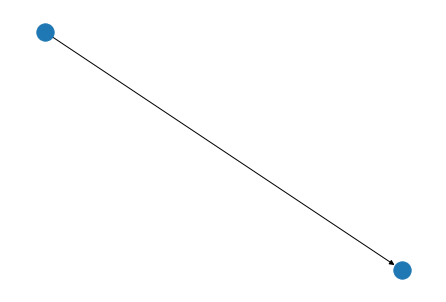

In [55]:
import networkx as nx
import matplotlib.pyplot as plt

g = nx.DiGraph()
g.add_edge(1,2)
nx.draw(g)
plt.show()

In [56]:
temp = {1: "Timeout Win", }

In [57]:
import os

for i in os.walk("vgdl/games"):
    for j in i[2]:
        if "_" not in j and j[-3:] == "txt":
            game_name = "vgdl_" + j.split(".")[0] + "-v0"
            env = gnwrapper.Monitor(gym.make(game_name, obs_type="objects"))
            if check_conditions(env):
                print("*"*30)
                for t in env.game.domain.terminations:
                    print("*"*10)
                    print(
                            t.limit,
                            t.score,
                            t.stype,
                            t.win)

            #print(game_name, env.game.domain.terminations)

NameError: name 'check_conditions' is not defined

In [58]:
def check_conditions(env):
    isSpriteCounter = True
    for i in env.game.domain.terminations:
        if not type(i) == vgdl.ontology.terminations.SpriteCounter:
            isSpriteCounter = False
    return isSpriteCounter

In [59]:
dir(env.game.domain.terminations[0])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'is_done',
 'limit',
 'score',
 'stype',
 'win']

In [505]:
def create_nodes(env):
    for i in env.game.domain.terminations:
        if(i.win):
            G = nx.DiGraph()
            create_win_graph(i.stype, env.game.domain.collision_eff,G,0,{})
    return G

In [506]:
def create_win_graph(stype, collision_eff,G,root_id,dic):
    last_id = root_id + 1
    for ef in collision_eff:
        print(stype,ef.actee_stype,ef.call_fn)
        if check_eff(ef.actor_stype,stype,ef.call_fn):
            print(stype,ef.actee_stype,ef.call_fn)
            at = ef.actee_stype
            if not at in dic:
                dic[at] = last_id
                #last_id += 1
            G.add_edge(dic[at],root_id)
            last_id,G,dic = create_win_graph(at,collision_eff,G,dic[at],dic)
    return last_id,G,dic



In [507]:
def check_eff(actor_stype, stype, call_fn):
    remove_fns = [vgdl.ontology.effects.killSprite]
    if(actor_stype == stype and call_fn in remove_fns):
        return True
    return False

box wall <function stepBack at 0x7fde5f3f3440>
box avatar <function bounceForward at 0x7fde5f3f3560>
box wall <function undoAll at 0x7fde5f3f34d0>
box box <function undoAll at 0x7fde5f3f34d0>
box hole <function killSprite at 0x7fde5f44c3b0>
box hole <function killSprite at 0x7fde5f44c3b0>
hole wall <function stepBack at 0x7fde5f3f3440>
hole avatar <function bounceForward at 0x7fde5f3f3560>
hole wall <function undoAll at 0x7fde5f3f34d0>
hole box <function undoAll at 0x7fde5f3f34d0>
hole hole <function killSprite at 0x7fde5f44c3b0>


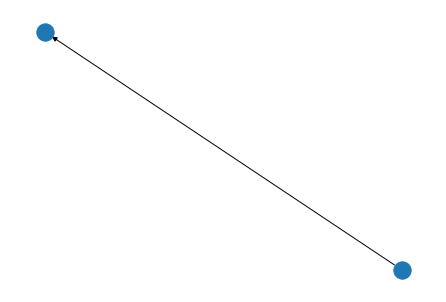

In [508]:
import networkx as nx
import matplotlib.pyplot as plt

env = gnwrapper.Monitor(gym.make("vgdl_sokoban-v0", obs_type="objects"))
G=create_nodes(env)
nx.draw(G)
plt.show()